# Task 3 - SVM y Árboles de Decisión
El objetivo es aplicar SVM (kernel lineal vs rbf) y árboles de decisión para comparar diferentes modelos utilizando un dataset de juegos de LoL.

### Prompts

Cumpliendo con las reglas del laboratorio, utilicé IA generativa para generar las gráficas con Matplotlib / Seaborn. Los prompts consisten en:

[Contexto] Eg. I have a weight vector w_final, a bias b_final, and two DFs of training values x_train and y_train.

[Task] Eg. I need to graph the 2D points from x_train colored by y_train (binary classification) as there's going to be concentric points. Then, I'll need to graph the decision boundary for the model on top of it.

Esto funciona porque se explica al inicio los objetos con los que se están trabajando, así se evitan errores de compatibilidad etc. Adicionalmente, siendo descriptivos y concretos con el task se deja poca "interpretabilidad" donde la IA pueda tomar alguna decisión "tonta".

Adicionalmente, al ir iterando busco ser lo más específico posible con los objetos que se están trabajando o dar alguna guía lo más "bajo nivel posible". Por ejemplo,

"I'll need the plot to fill the background above / under the decision threshold to identify the positive / negative class, no other changes"

También, como preferencia personal hago la mayoría de cosas "a manita" pero ocupo la ayuda ocasional para recordar sintaxis / documentación. No pretendo que conozco todas las operaciones de álgebra lineal de Numpy, pero colocar un prompt dónde pregunto "cómo se calculaban normas en Numpy" se me hace un poco overkill :)

## 1. Limpieza y Preprocesamiento

### Carga del Dataset

In [25]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("bobbyscience/league-of-legends-diamond-ranked-games-10-min")


df = pd.read_csv(f"{path}/high_diamond_ranked_10min.csv")

df.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


Luego que vimos que el Dataset fue cargado exitosamente, podemos empezar removiendo algunas de las columnas de más.

### Eliminiación de Redundancia
Empezamos obteniendo una lista de columnas, en mi caso no juego LoL y tuve que apoyarme de Gemini para consultar sobre que columnas no pueden verse desde el punto de vista del equipo Azul.

In [26]:
for col in df.columns:
    print(col)

gameId
blueWins
blueWardsPlaced
blueWardsDestroyed
blueFirstBlood
blueKills
blueDeaths
blueAssists
blueEliteMonsters
blueDragons
blueHeralds
blueTowersDestroyed
blueTotalGold
blueAvgLevel
blueTotalExperience
blueTotalMinionsKilled
blueTotalJungleMinionsKilled
blueGoldDiff
blueExperienceDiff
blueCSPerMin
blueGoldPerMin
redWardsPlaced
redWardsDestroyed
redFirstBlood
redKills
redDeaths
redAssists
redEliteMonsters
redDragons
redHeralds
redTowersDestroyed
redTotalGold
redAvgLevel
redTotalExperience
redTotalMinionsKilled
redTotalJungleMinionsKilled
redGoldDiff
redExperienceDiff
redCSPerMin
redGoldPerMin


Prompt: 'Remove every column with information we would not have at minute 10 from being on the blue team'

In [27]:
# List of columns that are HIDDEN info for the Blue Team
fog_of_war_cols = [
    'gameId', 
    
    # Impossible to calculate without seeing enemy totals
    'blueGoldDiff', 'blueExperienceDiff', 
    'redGoldDiff', 'redExperienceDiff',
    
    # Hidden Enemy Economy & XP
    'redTotalGold', 'redGoldPerMin',
    'redTotalExperience', 'redAvgLevel',
    
    # Hidden Enemy Vision
    'redWardsPlaced', 'redWardsDestroyed',
    
    # Hidden Specifics (You see total CS, but not specifically Jungle vs Lane)
    'redTotalJungleMinionsKilled'
]

df_blue_pov = df.drop(columns=fog_of_war_cols)

print("Columns available to Blue Team:")
print(df_blue_pov.columns.tolist())

Columns available to Blue Team:
['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalMinionsKilled', 'redCSPerMin']


Luego, únicamente para asegurarme confirmé si teníamos columnas adicionales que fueran derivados de otras.

Prompt: 'Any other columns that would be derivates of other ones? [lista]'

In [28]:
# List of "Derivative" columns to remove
derivative_cols = [
    'blueCSPerMin', 'blueGoldPerMin', 'redCSPerMin',  # Divide by 10 duplicates
    'blueEliteMonsters', 'redEliteMonsters',          # Sum duplicates
    'redFirstBlood',                                  # Binary mirror
    'redKills', 'redDeaths',                          # K/D mirrors (redKills = blueDeaths)
    'blueAvgLevel'                                    # Derived from Experience
]

# Drop them from your current list
df = df_blue_pov.drop(columns=derivative_cols, errors='ignore')
print(df.columns.tolist())

['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalMinionsKilled']


Luego de haber verificado que únicamente tenemos variables visibles para el equipo azul a los 10mins de juego, podemos proceder con el escalado.

### Escalado de Variables
Primero, separanmos en Train - Test, 80 - 20 utilizando un Stratified Split de SKLearn.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar en features / target
X = df.drop('blueWins', axis=1)
y = df['blueWins']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

Ahora, podemos realizar el escalado. Aquí vamos a mantener los conjuntos originales en adición al escalado, ya que únicamente buscamos utilizar las variables escaladas para SVM. En un árbol de decisión es mucho más informativo ver un nodo con "Oro > 4,000" que "Oro > 0.48"

In [30]:
# Fit transform en train y transform en test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Support Vector Machines

### SVM con Kernel Lineal

In [31]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


### SVM con Kernel RBF

In [32]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


### Comparación
Para la comparación podemos utilizar ClassificationReport al igual que matrices de confusión.

Linear Kernel
              precision    recall  f1-score   support

        Loss       0.72      0.72      0.72       990
         Win       0.72      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


RBF Kernel Report
              precision    recall  f1-score   support

        Loss       0.71      0.73      0.72       990
         Win       0.72      0.70      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



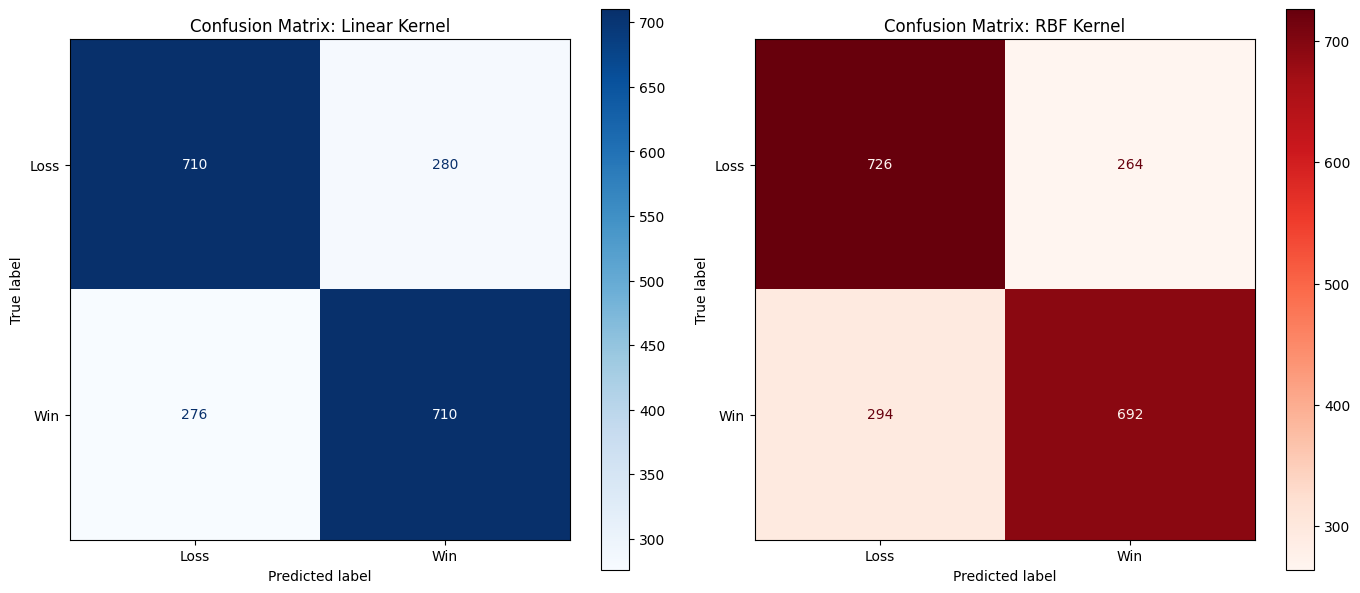

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Classification reports
print("Linear Kernel")
print(classification_report(y_test, svm_linear.predict(X_test_scaled), target_names=['Loss', 'Win']))

print("\nRBF Kernel Report")
print(classification_report(y_test, svm_rbf.predict(X_test_scaled), target_names=['Loss', 'Win']))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matrices de confusión
ConfusionMatrixDisplay.from_estimator(
    svm_linear, 
    X_test_scaled, 
    y_test, 
    display_labels=['Loss', 'Win'],
    cmap='Blues', 
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix: Linear Kernel")

ConfusionMatrixDisplay.from_estimator(
    svm_rbf, 
    X_test_scaled, 
    y_test, 
    display_labels=['Loss', 'Win'],
    cmap='Reds', 
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: RBF Kernel")

plt.tight_layout()
plt.show()

Podemos ver que el rendimiento realmente es bastante similar, únicamente tenemos variaciones en cuanto a FP vs FN utilizando RBF y Linear como kernels. En este caso, quiere decir que las partidas de LoL son linealmente separables por defecto. Es decir, la relación entre las variables y la victoria es directamente proporcional. No existe una relación "compleja" que el modelo deba descifrar. Básicamente, el juego involucra mucho factor "snowball", dónde el tener más oro, dragones, kills, etc. la probabilidad de ganar sube "en línea recta". También vale la pena notar que el modelo preferible (si tuviéramos que elegir entre estos dos, sin realizar algún otro tuneo de hiperparámetros) sería el Kernel Linea. Esto nos ayuda a tener una mayor epxlicabilidad, y el modelo resulta más eficiente computacionalmente. 

## 3. Árboles de Decisión

### Entrenamiento
Aquí vamos a utilizar los parámetros por defecto, al igual que un max depth de 3. En este caso, debemos de graficar el árbol y utilizando un depth más alto puede que no sea muy legible. Adicionalmente, parte del laboratorio es practica extraer información de los modelos, utilizando un árbol más profundo puede que sea más difícil interpretarlo.

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

### Visualización

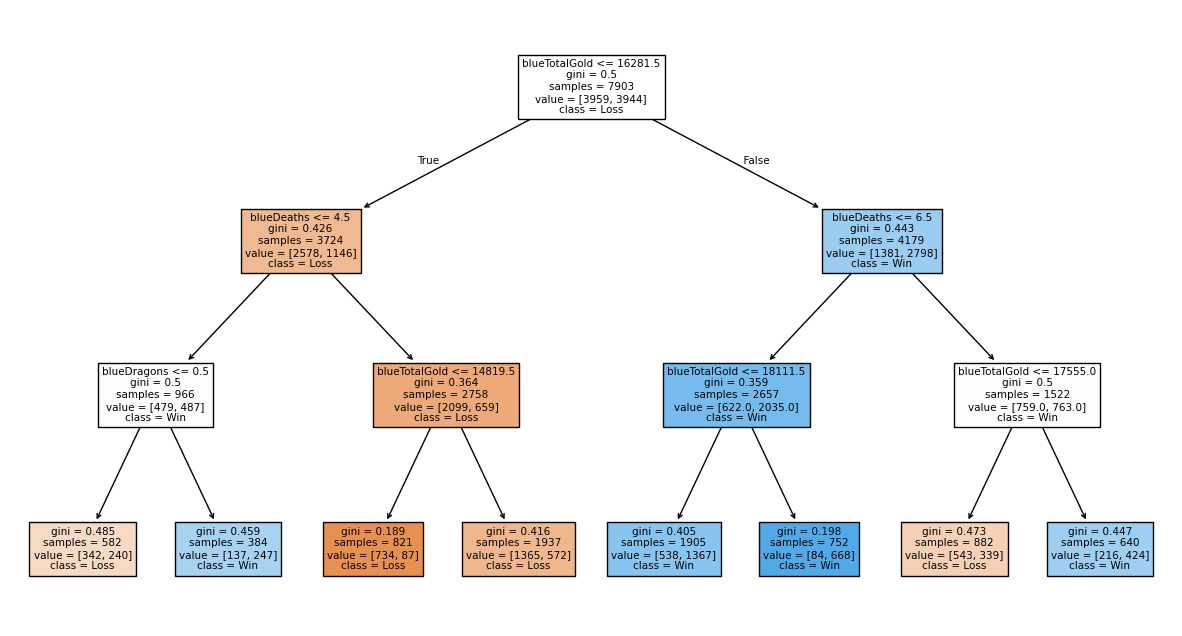

In [37]:
plt.figure(figsize=(15, 8))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=['Loss', 'Win'])
plt.show()

Al ver el árbol, nos queda bastante claro que una de las features principales es el oro. Podemos ver que es el nodo raíz, y adicionalmente tenemos separaciones basadas en oro en la mayoría de los casos. Adicionalmente, algunas de las otras variables pueden ser muertes y dragones. Sin embargo, estas se usan para identificar "partidas rescatables", dónde existe una desventaja en cuanto a oro acumulado pero al tener más dragones se puede compensar de cierta manera. 

### Feature Importance

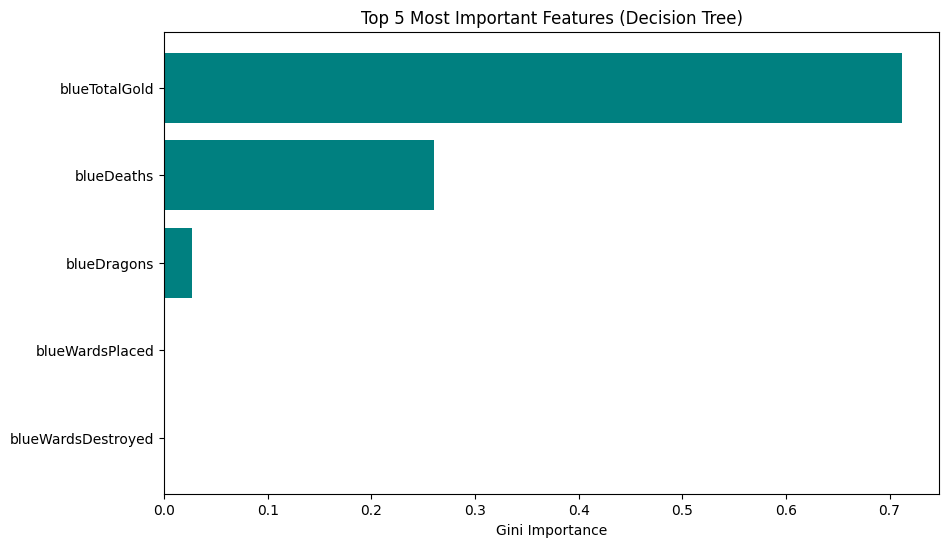

In [ ]:
# Extrar importancias
importances = tree.feature_importances_
feature_names = X.columns

# Convertir a DF
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(5)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color='teal')
plt.xlabel('Gini Importance')
plt.title('Top 5 Most Important Features (Decision Tree)')
plt.gca().invert_yaxis()
plt.show()

Tomando en cuenta el depth bajo, realmente no pudimos haber esperado una gran cantidad de variables involucradas. Aquí podemos apoyar un poco más nuestro análisis realizado anteriormente, dónde vemos que el monto total de oro al minuto 10 es el factor más importante al intentar predecir si Azul gana la partida seguido de muertes y por último dragones. Consultando con mis amigos que juegan LoL, obtuve un poco más de info dónde sus respuestas fueron

- "Lo más importante es tener 3,000 de oro para tener el primer ítem completo"
- "Los objetivos en gran parte, aunque también está el factor clave que una pelea lo puede decidir todo"

Además, apoyandome de Gemini llegué a la conclusión que el modelo tiene mucho sentido para las partidas de LoL. En este caso, el oro es la "raíz" dónde realmente se determina el outcome del juego. No se gana con una cantidad de minions o de kills, si no que se gana porque el farm o las kills dan oro. Adicionalmente, el poder adquirir items temprano causa un efecto de snowball masivo a lo largo de la partida. Adicionalmente, desde un principio consideré que el modelo iba a resultar algo "simple", ya que en los Esports existen una infinidad de factores a parte de los números en las tablas etc. Esto lo apoyo utilizando otra frase de un amigo que juega LoL:

- "Es demasiado situacional, los objetivos son variables dependiendo de la composición"

En resumen, el modelo tiene sentido pero puede ser muy simple.

## 4. Comparación Final
Las gráficas y classification reports fueron generados con IA

Prompt: I've got this tree [codigo] and these previously graphed confusion matrices [codigo], I need a single cell where I can see the confusion matrices side by side including classification reports

El prompt funciona al ser específico en los requerimientos, al conocer Matplotlib se bastante sobre lo que se puede hacer y puedo ser descriptivo en los prompts.

--- Linear Kernel Report ---
              precision    recall  f1-score   support

        Loss       0.72      0.72      0.72       990
         Win       0.72      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


--- RBF Kernel Report ---
              precision    recall  f1-score   support

        Loss       0.71      0.73      0.72       990
         Win       0.72      0.70      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


--- Decision Tree Report ---
              precision    recall  f1-score   support

        Loss       0.69      0.74      0.72       990
         Win       0.72      0.67      0.70       986

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.7

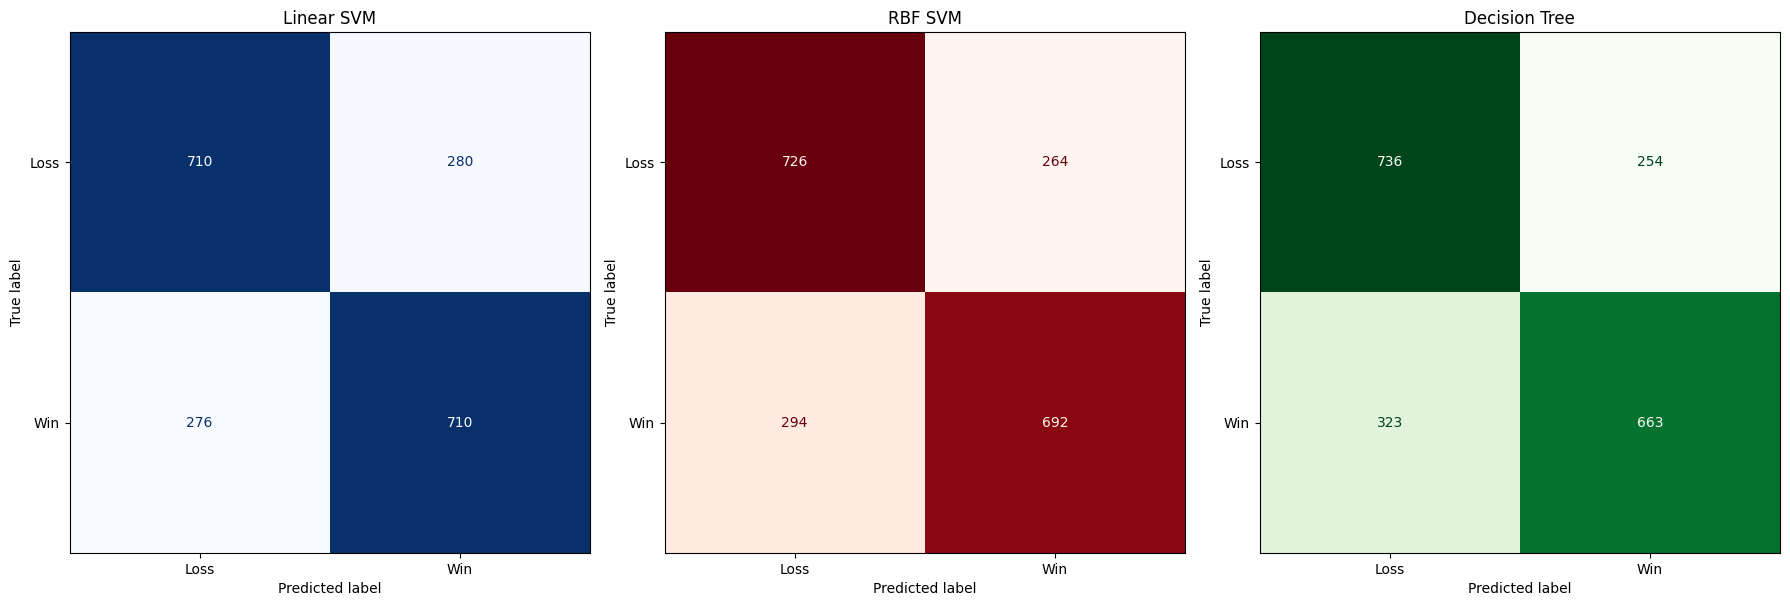

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

print("--- Linear Kernel Report ---")
print(classification_report(y_test, svm_linear.predict(X_test_scaled), target_names=['Loss', 'Win']))

print("\n--- RBF Kernel Report ---")
print(classification_report(y_test, svm_rbf.predict(X_test_scaled), target_names=['Loss', 'Win']))

print("\n--- Decision Tree Report ---")
print(classification_report(y_test, tree.predict(X_test), target_names=['Loss', 'Win']))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ConfusionMatrixDisplay.from_estimator(
    svm_linear, X_test_scaled, y_test, 
    display_labels=['Loss', 'Win'], cmap='Blues', ax=axes[0], colorbar=False
)
axes[0].set_title("Linear SVM")

# Plot RBF
ConfusionMatrixDisplay.from_estimator(
    svm_rbf, X_test_scaled, y_test, 
    display_labels=['Loss', 'Win'], cmap='Reds', ax=axes[1], colorbar=False
)
axes[1].set_title("RBF SVM")

# Plot Tree (Note: Using X_test, not X_test_scaled)
ConfusionMatrixDisplay.from_estimator(
    tree, X_test, y_test, 
    display_labels=['Loss', 'Win'], cmap='Greens', ax=axes[2], colorbar=False
)
axes[2].set_title("Decision Tree")

plt.tight_layout()
plt.show()

### Análisis de Métricas

En cuanto a Accuracy, realmente todos los modelos estuvieron bastante cercanos. En este caso, entre 0.71 y 0.72 no me sentiría cómodo coronando a un "ganador" entre los modelos. Realmente, sería de indagar un poco más sobre el problema a resolver / priorización de FPs vs FNs por ejemplo. Supongamos que queremos un modelo que nos indique cuando tirar "surrender" para ahorrar tiempo y pasar a la siguiente partida. En este caso, el error más costoso sería un FP en la clase "Loss". Aquí podríamos decir que el SVM Lineal es el modelo más adecuado, ya que cuenta con un Precision de 0.72 en pérdidas mientras que SVM RBF cuenta con 0.71 y el árbol de decisión con 0.69. Considerando los valores cercanos, probablemente diría que SVM Lineal es el más adecuado, pero no descartaría la posibilidad de "jugar" un poco más con los modelos de árboles. Adicionalmente, debemos de tomar en cuenta que en ML no nos importan únicamente las métricas si no que también la información que nos pueden proporcionar los modelos.

### Interpretabilidad

Para explicarle el resultado a un analista de e-sports, elegiría el Árbol de Decisión. Aunque ambos modelos tienen un rendimiento similar, el árbol ofrece una ventaja crítica en este contexto: la interpretabilidad visual. Mientras que el SVM (especialmente con kernels no lineales) opera como una "caja negra" matemática en dimensiones superiores que es imposible de visualizar intuitivamente, el árbol nos permite trazar una narrativa lógica del juego. Podríamos mostrarle al analista gráficamente cómo la diferencia de oro es el factor raíz que dicta la mayoría de las partidas. Pero también señalar ramas específicas, dónde a pesar de tener un déficit económico, asegurar un objetivo estratégico como un Dragón puede "salvar" la partida y cambiar el resultado a una victoria (como se ve en un análisis anterior).

Sin embargo, también vale la pena mencionar que el modelo actual es una simplificación de la realidad competitiva. En un entorno profesional de e-sports, un modelo más robusto utilizaría datos más complejos como posicionamiento, utilidad, composiciones, etc. Aunque estamos limitados por las variables del dataset, el árbol sigue siendo la mejor herramienta para traducir los datos a insights tácticos que un coach o analista puedan entender.

Pd. teniendo experiencia en e-sports (valo) la mayoría del tiempo evitamos las analíticas por estas mismas limitaciones, los datos son bastante difíciles de extraer y requieren mucha inversión / un equipo dedicado. Estoy 99% seguro que los equipos más grandes tienen equipos de datos, pero todo debería de trabajarse de la mano con el equipo técnico y el "ojímetro" de los coaches para validar la info que se obtiene.